In [3]:
import pandas as pd

df = pd.read_csv('News.csv')
print("Original dataset shape:", df.shape)
df.head()

Original dataset shape: (12520, 2)


,text,label
0,sing praise mahinda lose voice sri lanka disro...,1
1,kojc rally first time davao city appoint son god,1
2,bill gate people resist mrna tsunami exclude s...,1
3,cure covid19 forward budesonide asthma drug pl...,1
4,president trump form patriot party 81 day elec...,1


In [5]:
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)  
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)
df['clean_text'] = df['text'].apply(preprocess_text)
df.head()



,text,label,clean_text
0,sing praise mahinda lose voice sri lanka disro...,1,sing praise mahinda lose voice sri lanka disro...
1,kojc rally first time davao city appoint son god,1,kojc rally first time davao city appoint son god
2,bill gate people resist mrna tsunami exclude s...,1,bill gate people resist mrna tsunami exclude s...
3,cure covid19 forward budesonide asthma drug pl...,1,cure covid forward budesonide asthma drug pls ...
4,president trump form patriot party 81 day elec...,1,president trump form patriot party day electio...


In [6]:
df['clean_text'] = df['clean_text'].apply(lambda x: x.split())
df['clean_text']

0        [sing, praise, mahinda, lose, voice, sri, lank...
1        [kojc, rally, first, time, davao, city, appoin...
2        [bill, gate, people, resist, mrna, tsunami, ex...
3        [cure, covid, forward, budesonide, asthma, dru...
4        [president, trump, form, patriot, party, day, ...
                               ...                        
12515    [kosher, economy, businesse, israel, include, ...
12516    [scene, authority, force, vaccination, people,...
12517    [world, briefing, africa, south, africa, setba...
12518    [text, image, read, daniel, andrew, net, worth...
12519    [make, victoria, great, seem, even, victoria, ...
Name: clean_text, Length: 12520, dtype: object

# **Bag of Words Features**

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df['clean_text'].apply(lambda x: ' '.join(x)))

import pandas as pd
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print(bow_df.head())

   aa  aaaaaah  aaaaand  aadmi  aajtak  aam  aameen  aamir  aap  aapt  ...  \
0   0        0        0      0       0    0       0      0    0     0  ...   
1   0        0        0      0       0    0       0      0    0     0  ...   
2   0        0        0      0       0    0       0      0    0     0  ...   
3   0        0        0      0       0    0       0      0    0     0  ...   
4   0        0        0      0       0    0       0      0    0     0  ...   

   zuma  zumas  zumba  zumbi  zurich  zurmi  zyad  zyakhala  zygmunt  zyl  
0     0      0      0      0       0      0     0         0        0    0  
1     0      0      0      0       0      0     0         0        0    0  
2     0      0      0      0       0      0     0         0        0    0  
3     0      0      0      0       0      0     0         0        0    0  
4     0      0      0      0       0      0     0         0        0    0  

[5 rows x 28697 columns]


Logistic Regression


 Best Hyperparameters: {'C': 1, 'penalty': 'l2'}
 Logistic Regression → Training Accuracy: 0.9989
 Logistic Regression → Testing Accuracy: 0.9265
 Recall: 0.9571
 F1 Score: 0.9376
 AUC Score: 0.9810

 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91      1059
           1       0.92      0.96      0.94      1445

    accuracy                           0.93      2504
   macro avg       0.93      0.92      0.92      2504
weighted avg       0.93      0.93      0.93      2504



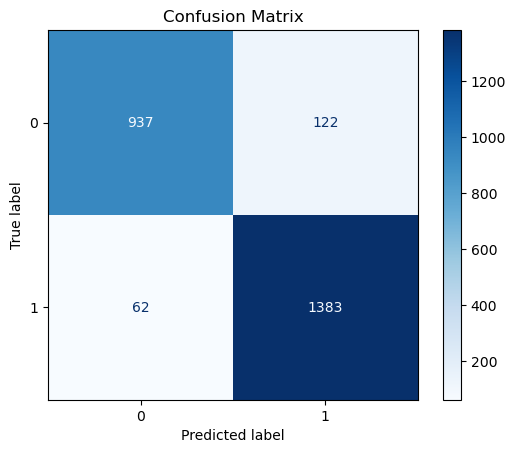

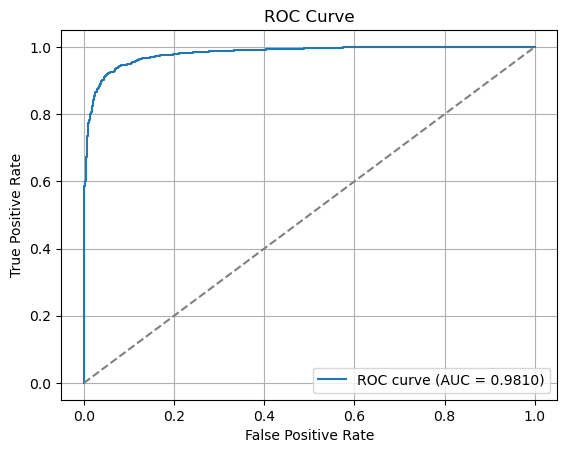

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    roc_curve,
    ConfusionMatrixDisplay,
    confusion_matrix
)
import matplotlib.pyplot as plt

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, df['label'], test_size=0.2, random_state=42
)

# Define model and parameter grid
log_reg = LogisticRegression(solver='liblinear', max_iter=1000)
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Grid search
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Predictions
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)
test_probs = best_model.predict_proba(X_test)[:, 1]

# Metrics
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)
recall = recall_score(y_test, test_preds)
f1 = f1_score(y_test, test_preds)
auc = roc_auc_score(y_test, test_probs)

print(" Best Hyperparameters:", grid_search.best_params_)
print(f" Logistic Regression → Training Accuracy: {train_acc:.4f}")
print(f" Logistic Regression → Testing Accuracy: {test_acc:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1 Score: {f1:.4f}")
print(f" AUC Score: {auc:.4f}")
print("\n Classification Report:\n", classification_report(y_test, test_preds))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Naive Bayes

Naive Bayes → Training Accuracy: 0.9671
Naive Bayes → Testing Accuracy: 0.9265
 Recall: 0.9190
 F1 Score: 0.9352
 AUC Score: 0.9768

 Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92      1059
           1       0.95      0.92      0.94      1445

    accuracy                           0.93      2504
   macro avg       0.92      0.93      0.93      2504
weighted avg       0.93      0.93      0.93      2504



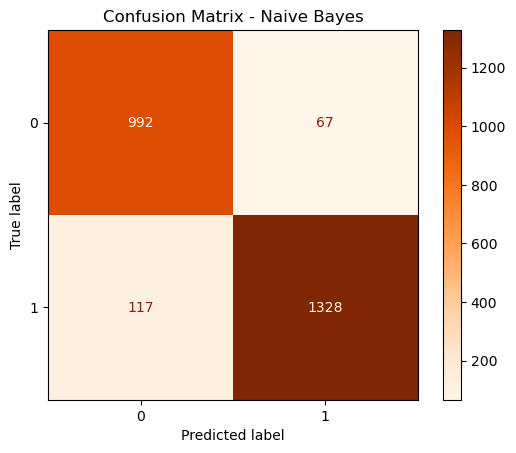

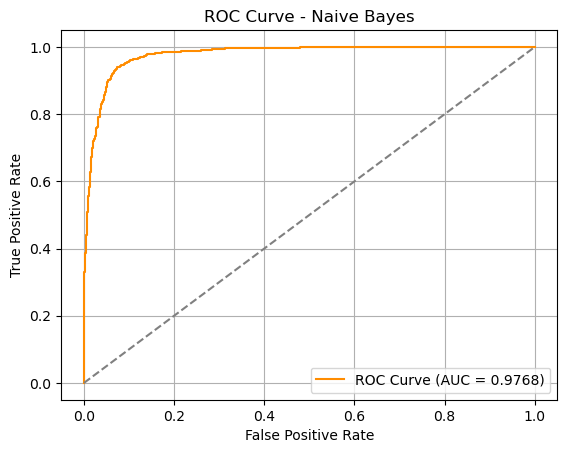

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve
)
import matplotlib.pyplot as plt


nb = MultinomialNB()
nb.fit(X_train, y_train)


train_preds = nb.predict(X_train)
test_preds = nb.predict(X_test)
test_probs = nb.predict_proba(X_test)[:, 1]  # For AUC & ROC


train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)
recall = recall_score(y_test, test_preds)
f1 = f1_score(y_test, test_preds)
auc = roc_auc_score(y_test, test_probs)


print(f"Naive Bayes → Training Accuracy: {train_acc:.4f}")
print(f"Naive Bayes → Testing Accuracy: {test_acc:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1 Score: {f1:.4f}")
print(f" AUC Score: {auc:.4f}")
print("\n Classification Report:\n", classification_report(y_test, test_preds))


cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix - Naive Bayes")
plt.show()


fpr, tpr, _ = roc_curve(y_test, test_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Naive Bayes")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


**Support Vector Machine **

SVM (Default) → Training Accuracy: 0.9910, Testing Accuracy: 0.9161
 Recall: 0.9260
 F1 Score: 0.9272
AUC Score: 0.9741

 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      1059
           1       0.93      0.93      0.93      1445

    accuracy                           0.92      2504
   macro avg       0.91      0.91      0.91      2504
weighted avg       0.92      0.92      0.92      2504



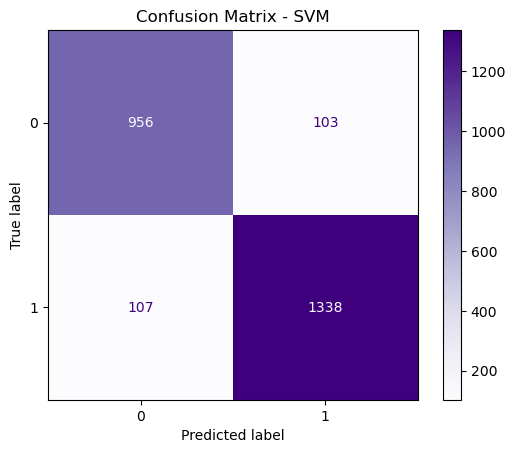

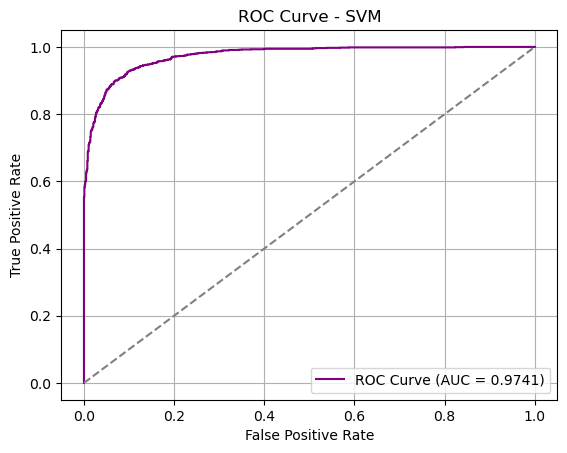

In [17]:
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve
)
import matplotlib.pyplot as plt


svm = SVC(probability=True)
svm.fit(X_train, y_train)


train_preds = svm.predict(X_train)
test_preds = svm.predict(X_test)
test_probs = svm.predict_proba(X_test)[:, 1]  


train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)
recall = recall_score(y_test, test_preds)
f1 = f1_score(y_test, test_preds)
auc = roc_auc_score(y_test, test_probs)


print(f"SVM (Default) → Training Accuracy: {train_acc:.4f}, Testing Accuracy: {test_acc:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")
print("\n Classification Report:\n", classification_report(y_test, test_preds))


cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Purples)
plt.title("Confusion Matrix - SVM")
plt.show()


fpr, tpr, _ = roc_curve(y_test, test_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})", color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


**Gradient Boosting **

Gradient Boosting → Training Accuracy: 0.8557, Testing Accuracy: 0.8446
 Recall: 0.9571
 F1 Score: 0.8767
 AUC Score: 0.9295

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.69      0.79      1059
           1       0.81      0.96      0.88      1445

    accuracy                           0.84      2504
   macro avg       0.87      0.82      0.83      2504
weighted avg       0.86      0.84      0.84      2504



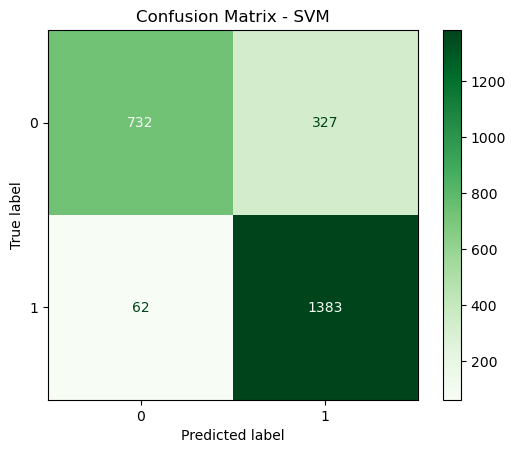

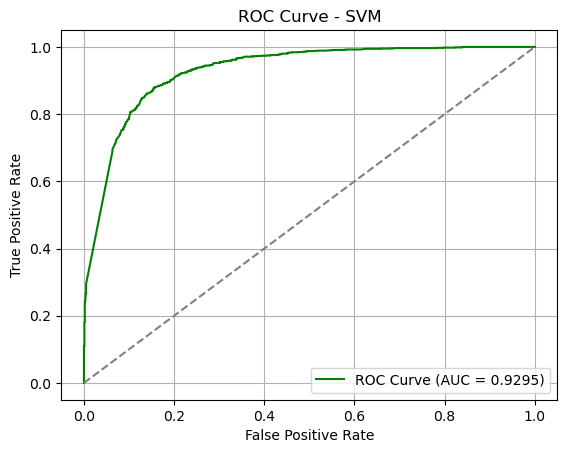

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve
)
import matplotlib.pyplot as plt


gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)


train_preds = gb.predict(X_train)
test_preds = gb.predict(X_test)
test_probs = gb.predict_proba(X_test)[:, 1]  # For AUC


train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)
recall = recall_score(y_test, test_preds)
f1 = f1_score(y_test, test_preds)
auc = roc_auc_score(y_test, test_probs)


print(f"Gradient Boosting → Training Accuracy: {train_acc:.4f}, Testing Accuracy: {test_acc:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1 Score: {f1:.4f}")
print(f" AUC Score: {auc:.4f}")
print("\n Classification Report:\n", classification_report(y_test, test_preds))


cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix - SVM")
plt.show()


fpr, tpr, _ = roc_curve(y_test, test_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})", color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


C:\Users\VIP\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Feedforward Neural Network Results:
 Training Accuracy: 1.0000
 Testing Accuracy: 0.9373
 Recall: 0.9585
 F1 Score: 0.9464
 AUC Score: 0.9789

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92      1059
           1       0.93      0.96      0.95      1445

    accuracy                           0.94      2504
   macro avg       0.94      0.93      0.94      2504
weighted avg       0.94      0.94      0.94      2504



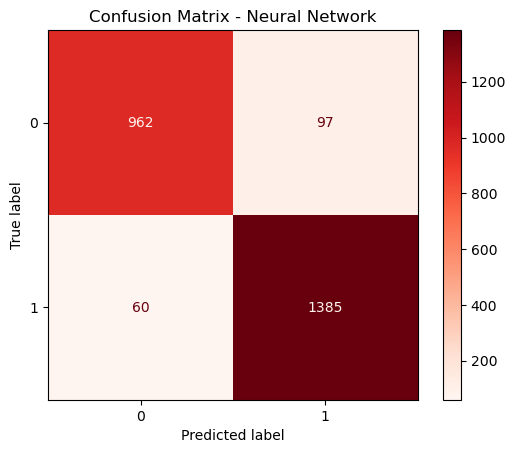

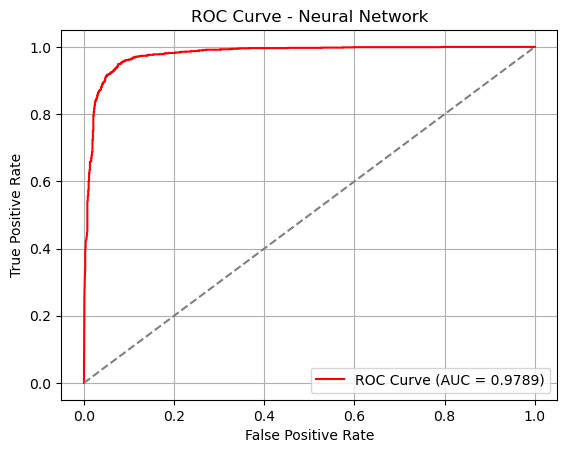

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve
)


X_train_np = X_train.toarray() if hasattr(X_train, "toarray") else np.asarray(X_train)
X_test_np = X_test.toarray() if hasattr(X_test, "toarray") else np.asarray(X_test)

if len(X_train_np.shape) == 1:
    X_train_np = X_train_np.reshape(-1, 1)
if len(X_test_np.shape) == 1:
    X_test_np = X_test_np.reshape(-1, 1)


y_train_np = np.array(y_train)
y_test_np = np.array(y_test)


num_classes = len(np.unique(y_train_np))
if num_classes > 2:
    y_train_cat = to_categorical(y_train_np)
    y_test_cat = to_categorical(y_test_np)
else:
    y_train_cat = y_train_np
    y_test_cat = y_test_np


model1 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_np.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1 if num_classes == 2 else num_classes, activation='sigmoid' if num_classes == 2 else 'softmax')
])
model1.compile(
    optimizer='adam',
    loss='binary_crossentropy' if num_classes == 2 else 'categorical_crossentropy',
    metrics=['accuracy']
)


model1.fit(X_train_np, y_train_cat, epochs=10, batch_size=32, verbose=0)


train_preds = model1.predict(X_train_np)
test_preds = model1.predict(X_test_np)

train_labels = (train_preds > 0.5).astype(int) if num_classes == 2 else np.argmax(train_preds, axis=1)
test_labels = (test_preds > 0.5).astype(int) if num_classes == 2 else np.argmax(test_preds, axis=1)


train_acc = accuracy_score(y_train_np, train_labels)
test_acc = accuracy_score(y_test_np, test_labels)
recall = recall_score(y_test_np, test_labels, average='binary' if num_classes == 2 else 'macro')
f1 = f1_score(y_test_np, test_labels, average='binary' if num_classes == 2 else 'macro')
auc = roc_auc_score(
    y_test_np,
    test_preds if num_classes == 2 else y_test_cat,
    multi_class='ovr' if num_classes > 2 else 'raise'
)


print("\nFeedforward Neural Network Results:")
print(f" Training Accuracy: {train_acc:.4f}")
print(f" Testing Accuracy: {test_acc:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1 Score: {f1:.4f}")
print(f" AUC Score: {auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test_np, test_labels))


cm = confusion_matrix(y_test_np, test_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix - Neural Network")
plt.show()


if num_classes == 2:
    fpr, tpr, _ = roc_curve(y_test_np, test_preds)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})", color='red')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Neural Network")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


Epoch 1/5


C:\Users\VIP\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7088 - loss: 0.5341 - val_accuracy: 0.9212 - val_loss: 0.1944
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9611 - loss: 0.1173 - val_accuracy: 0.9242 - val_loss: 0.2015
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9887 - loss: 0.0372 - val_accuracy: 0.9142 - val_loss: 0.2717
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9946 - loss: 0.0187 - val_accuracy: 0.9212 - val_loss: 0.3450
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9977 - loss: 0.0085 - val_accuracy: 0.9212 - val_loss: 0.3937
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

CNN for Text Classification Results:
 Training Accuracy: 0.9920
 Testing Accuracy: 0.9217
 Recall: 0.9294
 F1 Score: 0.9320
 AUC Score: 0.9768

Classification Report:
               precision    recall  f1-score   support

           0       0.90    

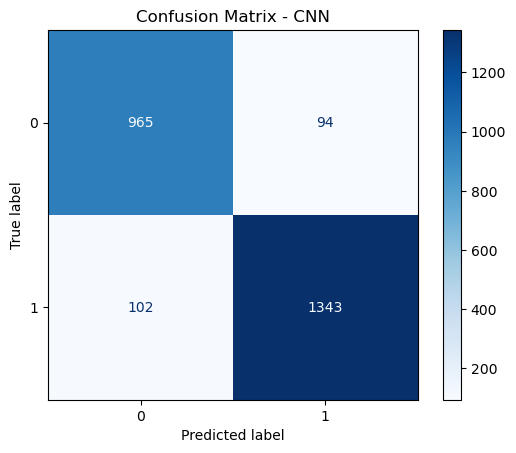

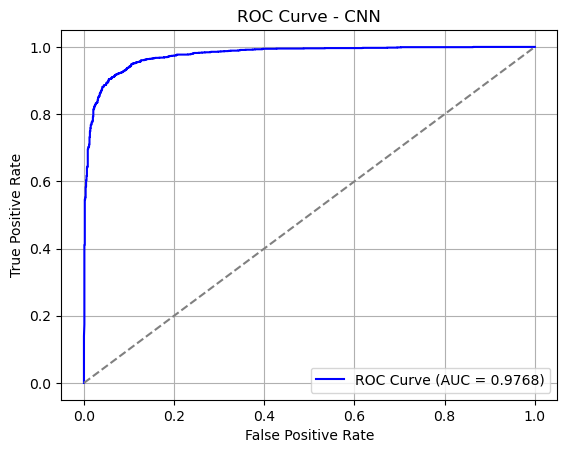

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Prepare text and labels
texts = df['text'].astype(str).tolist()
labels = df['label'].values

# Split data
X_train_text, X_test_text, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenization and padding
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# CNN model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Conv1D(128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

# Predictions
train_preds = (model.predict(X_train_pad) > 0.5).astype(int)
test_preds = (model.predict(X_test_pad) > 0.5).astype(int)
test_probs = model.predict(X_test_pad)

# Evaluation
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)
recall = recall_score(y_test, test_preds)
f1 = f1_score(y_test, test_preds)
auc = roc_auc_score(y_test, test_probs)

# Print metrics
print("\nCNN for Text Classification Results:")
print(f" Training Accuracy: {train_acc:.4f}")
print(f" Testing Accuracy: {test_acc:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1 Score: {f1:.4f}")
print(f" AUC Score: {auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, test_preds))

# Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - CNN")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CNN")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
